# Entrainement du modèle

Pré-requis :
- Exécuter l'intégralité du code preprocessing
- Installer toutes les bibliothèques nécessaires

Nous allons ici entrainer le modèle U-net. L'entrainement aura été effectué en 2 parties : une première sur une base de données réduite à un dossier d'images et une deuxième dans laquelle le modèle a été entrainé sur 3 dossiers d'images

In [ ]:
#### BIBLIOTHEQUES ####

import os
import numpy as np
import cv2
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
#### CHEMINS ####

vv_dir = '../Final_database/vv/'
vh_dir = '../Final_database/vh/'
water_body_dir = '../Final_database/water_body_label/'
flood_label_dir = '../Final_database/flood_label/'
preprocessed_dir = '../preprocessed_data/'


## On charge les données du preprocessing et on créé 2 dataset : train et validation

In [ ]:
def load_images_from_folder(folder, label_folder):
    # Initialiser les tableaux NumPy avec la taille requise
    num_images = len(glob.glob(os.path.join(folder, '*.png')))
    images = np.zeros((num_images, 256, 256), dtype=np.uint8)
    labels = np.zeros((num_images, 256, 256), dtype=np.uint8)

    for i, filename in enumerate(glob.glob(os.path.join(folder, '*.png'))):
        # Charger l'image en uint8
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Erreur de chargement de l'image: {filename}")
            continue  # Passer à l'image suivante
        
        img = cv2.resize(img, (256, 256))  # Redimensionner
        images[i] = img  # Remplir le tableau NumPy
        
        # Charger le label correspondant
        label_name = os.path.basename(filename).replace('_vv.png', '.png')
        label_path = os.path.join(label_folder, label_name)
        label_img = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        if label_img is None:
            print(f"Erreur de chargement du label: {label_path}")
            continue  # Passer au label suivant
        
        label_img = cv2.resize(label_img, (256, 256))
        binary_label = (label_img > 0).astype(np.uint8)
        labels[i] = binary_label  # Remplir le tableau NumPy

    # Retirer les images et labels qui n'ont pas pu être chargés
    valid_indices = np.where(images.sum(axis=(1, 2)) > 0)[0]
    return images[valid_indices], labels[valid_indices]


In [5]:
images, labels = load_images_from_folder(vv_dir,water_body_dir)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

## On définit ensuite l'architecture de notre U-Net

In [ ]:
#### MODELE ####

def unet_model_with_water_body(input_shape=(256, 256, 1)):

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(p2)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    # Output layer (flooded area prediction)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    # Compile the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = unet_model_with_water_body()
model.summary()


I0000 00:00:1730651765.432068    3945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730651765.432553    3945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730651765.432906    3945 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730651765.433843    3945 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │     65,664 │ max_pooling2d_1[… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 256,  │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │         65 │ conv2d_7[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 910,913 (3.47 MB)

 Trainable params: 910,913 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

## Entrainement avec création de checkpoints

In [7]:
#### TRAINING #####

# Ensure the directory for saving model parameters exists
checkpoint_dir = 'model_parameters_3'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the checkpoint callback to save model parameters at specified epochs
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_freq='epoch',
)

# Train the U-Net model with the checkpoint callback
history = model.fit(X_train, y_train, epochs=20, batch_size=4, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/20


/home/benoit/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1730651782.505095    4207 service.cc:146] XLA service 0x7723cc009150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730651782.505122    4207 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2024-11-03 17:36:22.642293: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-03 17:36:23.105048: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
E0000 00:00:1730651786.460175    4207 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warm

  1/852 ━━━━━━━━━━━━━━━━━━━━ 4:01:07 17s/step - accuracy: 0.9951 - loss: 0.0204

I0000 00:00:1730651796.687064    4207 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


852/852 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9808 - loss: 0.1110

2024-11-03 17:38:03.786072: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-03 17:38:04.676948: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


852/852 ━━━━━━━━━━━━━━━━━━━━ 114s 114ms/step - accuracy: 0.9808 - loss: 0.1110 - val_accuracy: 0.9820 - val_loss: 0.0662
Epoch 2/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 103s 121ms/step - accuracy: 0.9793 - loss: 0.0783 - val_accuracy: 0.9820 - val_loss: 0.0641
Epoch 3/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 111s 130ms/step - accuracy: 0.9785 - loss: 0.0779 - val_accuracy: 0.9820 - val_loss: 0.0631
Epoch 4/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 111s 130ms/step - accuracy: 0.9785 - loss: 0.0755 - val_accuracy: 0.9820 - val_loss: 0.0704
Epoch 5/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 111s 131ms/step - accuracy: 0.9766 - loss: 0.0806 - val_accuracy: 0.9820 - val_loss: 0.0609
Epoch 6/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 112s 131ms/step - accuracy: 0.9808 - loss: 0.0741 - val_accuracy: 0.9820 - val_loss: 0.0630
Epoch 7/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 112s 131ms/step - accuracy: 0.9801 - loss: 0.0708 - val_accuracy: 0.9820 - val_loss: 0.0574
Epoch 8/20
852/852 ━━━━━━━━━━━━━━━━━━━━ 111s 131ms/step - accuracy: 0.9820 - loss: 0.06

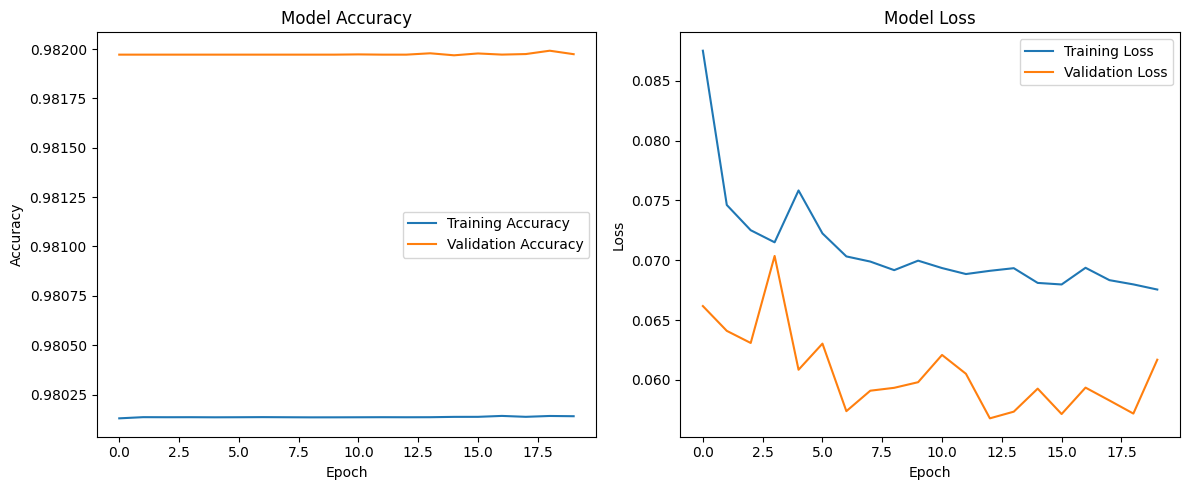

In [11]:
def plot_training_history(history):
    # Extract metrics from history
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.savefig('training_history_3.png')
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history)